# 執行週期(epoch)改為10

## 載入套件

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

## 設定參數

In [2]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [3]:
# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transforms.ToTensor())

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transforms.ToTensor())

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 步驟2：資料清理，此步驟無需進行

## 步驟3：特徵工程，此步驟無需進行

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [4]:
# 建立模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 256), 
    nn.Dropout(0.2),
    torch.nn.Linear(256, 10), 
).to(device)

## 步驟6：結合訓練資料及模型，進行模型訓練

In [5]:
epochs = 10
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=600)

# 設定優化器(optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         if batch_idx == 0 and epoch == 1: print(data[0])

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [    0 / 60000] (0 %)  Loss: 2.315393
Epoch 1: [ 6000 / 60000] (10 %)  Loss: 2.015262
Epoch 1: [12000 / 60000] (20 %)  Loss: 1.780742
Epoch 1: [18000 / 60000] (30 %)  Loss: 1.558802
Epoch 1: [24000 / 60000] (40 %)  Loss: 1.328512
Epoch 1: [30000 / 60000] (50 %)  Loss: 1.217832
Epoch 1: [36000 / 60000] (60 %)  Loss: 0.980923
Epoch 1: [42000 / 60000] (70 %)  Loss: 0.958156
Epoch 1: [48000 / 60000] (80 %)  Loss: 0.712088
Epoch 1: [54000 / 60000] (90 %)  Loss: 0.728609
Epoch 2: [    0 / 60000] (0 %)  Loss: 0.688114
Epoch 2: [ 6000 / 60000] (10 %)  Loss: 0.540672
Epoch 2: [12000 / 60000] (20 %)  Loss: 0.640921
Epoch 2: [18000 / 60000] (30 %)  Loss: 0.552893
Epoch 2: [24000 / 60000] (40 %)  Loss: 0.570941
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.627792
Epoch 2: [36000 / 60000] (60 %)  Loss: 0.503483
Epoch 2: [42000 / 60000] (70 %)  Loss: 0.600652
Epoch 2: [48000 / 60000] (80 %)  Loss: 0.416698
Epoch 2: [54000 / 60000] (90 %)  Loss: 0.460870
Epoch 3: [    0 / 60000] (0 %)  Loss: 0.46

## 對訓練過程的損失繪圖

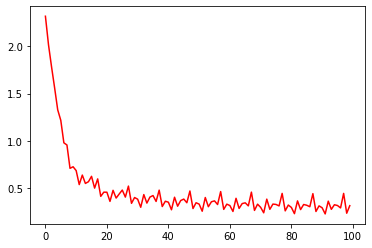

In [6]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)

In [7]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += criterion(output, target).item()
        
        # 預測
        pred = output.argmax(dim=1, keepdim=True)  
        
        # 正確筆數
        correct += pred.eq(target.view_as(pred)).sum().item()

# 平均損失
test_loss /= len(test_loader.dataset)
# 顯示測試結果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')

平均損失: 0.0003, 準確率: 9165/10000 (92%)



## 實際比對測試資料的前20筆

In [8]:
# 實際預測 20 筆資料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比對
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4


## 步驟8：評估，暫不進行

## 步驟9：模型佈署

## 步驟10：新資料預測

In [9]:
# 使用小畫家，繪製 0~9，實際測試看看
from skimage import io
from skimage.transform import resize
import numpy as np

# 讀取影像並轉為單色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 縮為 (28, 28) 大小的影像
    image_resized = resize(image1, (28, 28), anti_aliasing=True)    
    X1 = image_resized.reshape(1,28, 28) #/ 255.0

    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = torch.FloatTensor(1-X1).to(device)

    # 預測
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 0 6
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 7
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 3
actual/prediction: 8 8
actual/prediction: 9 1
